In [1]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
data_prep_needed = False
if data_prep_needed:
    %run gather_eeg_data.py

In [3]:
# Load the .mat file
eeg_mat = scipy.io.loadmat('eeg_data_from_s3/EEG_all_epochs.mat')
eog_mat = scipy.io.loadmat('eeg_data_from_s3/EOG_all_epochs.mat')

In [4]:
print(eeg_mat.keys())
print(np.shape(eeg_mat['EEG_all_epochs']))
print(type(eeg_mat['EEG_all_epochs']))

dict_keys(['__header__', '__version__', '__globals__', 'EEG_all_epochs', 'fs'])
(4514, 512)
<class 'numpy.ndarray'>


In [5]:
print(eog_mat.keys())
print(np.shape(eog_mat['EOG_all_epochs']))
print(type(eog_mat['EOG_all_epochs']))

dict_keys(['__header__', '__version__', '__globals__', 'EOG_all_epochs', 'fs'])
(3400, 512)
<class 'numpy.ndarray'>


The signal-to-noise ratio is given by:
$$
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left(\frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
$$


Here we can scale the noise according to SNR.

The range (0, 10) means:

0 dB → signal and noise have equal power

10 dB → signal power is 10× higher than noise

20 dB → signal is 100× higher, and so on

In [6]:
def add_noise_at_snr(clean_signal, noise_signal, snr_db):
    """
    Add noise_signal to clean_signal to obtain the desired SNR in dB.    
    Both signals should be NumPy arrays of the same shape.
    """
    # Power of the clean signal
    power_signal = np.mean(clean_signal ** 2)

    # Power of the noise
    power_noise = np.mean(noise_signal ** 2)

    # Scale factor for noise to match desired SNR
    snr_linear = 10 ** (snr_db / 10)
    scale_factor = np.sqrt(power_signal / (power_noise * snr_linear))

    # Scale noise and add to clean signal
    scaled_noise = noise_signal * scale_factor
    noisy_signal = clean_signal + scaled_noise
    return noisy_signal


In [7]:
class AugmentedEEGDataset(Dataset):
    def __init__(self, clean_eeg, eog_artifacts, snr_range=(-5, 5)):
        self.clean_eeg = torch.tensor(clean_eeg, dtype=torch.float32)
        self.eog_artifacts = torch.tensor(eog_artifacts, dtype=torch.float32)
        self.snr_range = snr_range

    def __len__(self):
        return len(self.clean_eeg)

    def __getitem__(self, idx):
        clean = self.clean_eeg[idx].numpy()
        artifact = self.eog_artifacts[np.random.randint(0, len(self.eog_artifacts))].numpy()
        snr_db = np.random.uniform(*self.snr_range)
        noisy = add_noise_at_snr(clean, artifact, snr_db)
        return torch.tensor(noisy, dtype=torch.float32), self.clean_eeg[idx]


In [8]:


# First split: train+val vs. test (e.g., 80/20)
eeg_trainval, eeg_test = train_test_split(eeg_mat['EEG_all_epochs'], test_size=0.2, random_state=42)

# Second split: train vs. val (e.g., 75/25 of 80%)
eeg_train, eeg_val = train_test_split(eeg_trainval, test_size=0.25, random_state=42)


In [9]:
# Define dataset with on-the-fly augmentation
train_dataset = AugmentedEEGDataset(eeg_train, eog_mat['EOG_all_epochs'], snr_range=(-7, 2))
val_dataset   = AugmentedEEGDataset(eeg_val,   eog_mat['EOG_all_epochs'], snr_range=(-7, 2))
test_dataset  = AugmentedEEGDataset(eeg_test,  eog_mat['EOG_all_epochs'], snr_range=(-7, 2))

# Create a PyTorch dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Before we begin any training, let's visualise some SNR effects

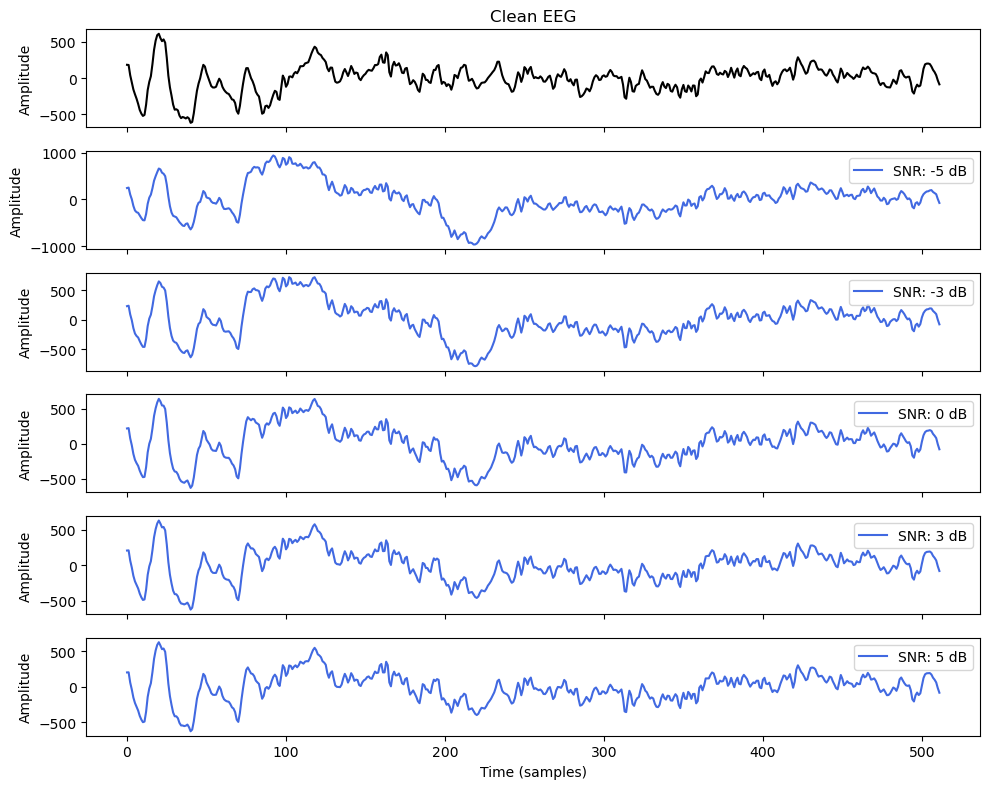

In [10]:
# Choose a clean EEG and EOG artifact (same length)
clean = eeg_mat['EEG_all_epochs'][0]
artifact = eog_mat['EOG_all_epochs'][0]

# Define SNR levels to visualize
snr_levels = [-5, -3, 0, 3, 5]

# Create subplot
fig, axs = plt.subplots(len(snr_levels) + 1, 1, figsize=(10, 8), sharex=True)

# Plot original clean signal
axs[0].plot(clean, color='black')
axs[0].set_title('Clean EEG')
axs[0].set_ylabel('Amplitude')

# Plot noisy versions
for i, snr in enumerate(snr_levels):
    noisy = add_noise_at_snr(clean, artifact, snr)
    axs[i + 1].plot(noisy, label=f'SNR: {snr} dB', color='royalblue')
    axs[i + 1].legend(loc='upper right')
    axs[i + 1].set_ylabel('Amplitude')

axs[-1].set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()


Below, we find slightly more complex forward-pass than needed however this will then support dynamic batch-sizes on ONNX deployment (not fixed to batch-size 1)

In [11]:
class EEGDenoiseLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.3):
        super(EEGDenoiseLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h0=None, c0=None):
        batch_size = x.size(0)
        device = x.device

        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out)
        return out

class EEGDenoiseLSTM_basic(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.3):
        super(EEGDenoiseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value per time step

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        dropped = self.dropout(lstm_out)
        out = self.fc(dropped)
        return out

In [12]:

model = EEGDenoiseLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15


In the code below, we'll switch between weights been updated or not using
model.train() and model.eval()

We'll also use patience (early stopping) to avoid overfitting

In [13]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

In [14]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for noisy, clean in train_loader:
        noisy = noisy.unsqueeze(-1)
        clean = clean.unsqueeze(-1)
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.unsqueeze(-1)
            clean = clean.unsqueeze(-1)
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
    
    # early stop logic
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        best_model_state = model.state_dict()  # Save best model weights
    else:
        patience_counter += 1
        print(f"No improvement in val loss for {patience_counter} epochs.")
    
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/15 - Train Loss: 51931.0920, Val Loss: 49386.8228
Epoch 2/15 - Train Loss: 50948.8115, Val Loss: 48493.7501
Epoch 3/15 - Train Loss: 50072.9394, Val Loss: 47665.6554
Epoch 4/15 - Train Loss: 49356.7191, Val Loss: 47011.4968
Epoch 5/15 - Train Loss: 48688.1793, Val Loss: 46364.7361
Epoch 6/15 - Train Loss: 48019.1221, Val Loss: 45737.0141
Epoch 7/15 - Train Loss: 47364.6739, Val Loss: 45160.7866
Epoch 8/15 - Train Loss: 46791.0031, Val Loss: 44552.0057
Epoch 9/15 - Train Loss: 46250.9508, Val Loss: 44030.7146
Epoch 10/15 - Train Loss: 45651.4908, Val Loss: 43578.9568
Epoch 11/15 - Train Loss: 45168.2915, Val Loss: 43013.4764
Epoch 12/15 - Train Loss: 44608.2925, Val Loss: 42469.7964
Epoch 13/15 - Train Loss: 44141.5105, Val Loss: 41998.9040
Epoch 14/15 - Train Loss: 43655.4198, Val Loss: 41549.6777
Epoch 15/15 - Train Loss: 43154.7874, Val Loss: 41141.7742


In [15]:
if best_model_state is not None:
    torch.save(best_model_state, "best_model.pth")

In [16]:
# to reload best model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

EEGDenoiseLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Show performance during training visually

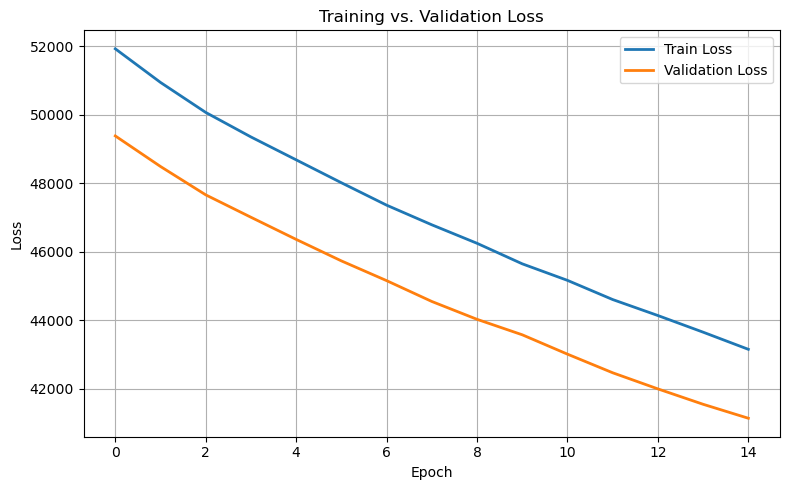

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for noisy, clean in test_loader:
        noisy = noisy.unsqueeze(-1)
        clean = clean.unsqueeze(-1)
        output = model(noisy)
        loss = criterion(output, clean)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 43307.1511


Export to ONNX. Initialise the cell and hidden states too, to allow dynamic batch sizes (avoids a warning, and being limited to batchsize 1 only)

In [19]:
!pip install onnx
dummy_input = torch.randn(2, 512, 1)  # batch size = 2
dummy_h0 = torch.zeros(1, 2, 64)      # (num_layers, batch, hidden_size)
dummy_c0 = torch.zeros(1, 2, 64)

torch.onnx.export(
    model,
    (dummy_input, dummy_h0, dummy_c0),
    "eeg_denoising_model.onnx",
    input_names=["noisy_input", "h0", "c0"],
    output_names=["clean_output"],
    dynamic_axes={
        "noisy_input": {0: "batch_size"},
        "h0": {1: "batch_size"},
        "c0": {1: "batch_size"},
        "clean_output": {0: "batch_size"},
    },
    opset_version=11
)



/opt/conda/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [ ]:
# ONNX will discard hidden and cell state h0 and c0
# for models where we want to maintain this state we should feed it back in
# for this use-case this isn't required

In [20]:
import onnxruntime as ort
import numpy as np

# Load model
sess = ort.InferenceSession("eeg_denoising_model.onnx")

# Input dimensions
batch_size = 10
seq_len = 512
hidden_size = 64
num_layers = 1

# Create input data
noisy_np = eeg_mat["EEG_all_epochs"][0:10][:,:,np.newaxis].astype(np.float32)
h0 = np.zeros((num_layers, batch_size, hidden_size), dtype=np.float32)
c0 = np.zeros((num_layers, batch_size, hidden_size), dtype=np.float32)

# Run inference
inputs = {
    "noisy_input": noisy_np,
    "h0": h0,
    "c0": c0
}
outputs = sess.run(None, inputs)
clean = outputs[0]

print("Output shape:", clean.shape)  # Should be (10, 512, 1)


Output shape: (10, 512, 1)


In [21]:
with torch.no_grad():
    torch_out = model(torch.from_numpy(noisy_np)).numpy()
    print(torch_out.shape)

print("Max absolute difference:", np.max(np.abs(outputs[0] - torch_out)))


(10, 512, 1)
Max absolute difference: 3.0517578e-05
